# Mineração de Dados / Statistical Machine Learning
    Lista 1
    Rafael Izbicki

# Importando as bibliotecas

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import warnings; warnings.simplefilter('ignore')

# Lista 01 
**Exercı́cio 1**
* Considere o banco houses_to_rent_v2 (https://www.dropbox.com/s/8auhk2zaogovjvn/houses_to_rent_v2.csv?dl=0), que contém o valor (em reais) do aluguel de imóveis no Brasil. Você pode trabalhar apenas com os imóveis localizados em São Paulo, Rio de Janeiro e Belo Horizonte.
1. Divida o conjunto de dados em para treinamento e teste. Explique como decidiu qual porcentagem deixar
para cada um.
2. Utilizando o conjunto de treinamento, ajuste uma regressão (i) via mı́nimos quadrados, (ii) via lasso (usando validação-cruzada no treinamento para escolher λ) e (iii) (Pós-graduação apenas) regressão ridge. Qual o melhor valor de λ encontrado para o lasso?
3. Qual dos métodos acima apresentou melhores resultados? Responda essa pergunta utilizando o conjunto de teste e o melhor valor de λ encontrado. Inclua os intervalos de confiança para o risco preditivo nos seus resultados.
4. Interprete os resultados do melhor modelo encontrado (via coeficientes). Ele faz sentido?
5. Includa todas as interações entre as variáveis observadas e repita o ajuste do método de mı́nimos quadrados e o lasso. Como esses ajustes se comparam em relação aos anteriores? Qual foi o melhor modelo encontrado?Esses resultados são esperados?

### Importando os dados para "df"

In [2]:
df = pd.read_csv('houses_to_rent_v2.csv')

In [3]:
df

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,rent amount (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,3300
1,São Paulo,320,4,4,0,20,acept,not furnished,4960
2,Porto Alegre,80,1,1,1,6,acept,not furnished,2800
3,Porto Alegre,51,2,1,0,2,acept,not furnished,1112
4,São Paulo,25,1,1,0,1,not acept,not furnished,800
...,...,...,...,...,...,...,...,...,...
10687,Porto Alegre,63,2,1,1,5,not acept,furnished,1478
10688,São Paulo,285,4,4,4,17,acept,not furnished,15000
10689,Rio de Janeiro,70,3,3,0,8,not acept,furnished,6000
10690,Rio de Janeiro,120,2,2,2,8,acept,furnished,12000


# Seleciando apenas as cidades de São Paulo / Rio de Janeiro / Belo Horizonte

In [4]:
df=df.loc[df['city'].isin(['São Paulo', 'Rio de Janeiro','Belo Horizonte'])]

In [5]:
df['city'].unique()

array(['São Paulo', 'Rio de Janeiro', 'Belo Horizonte'], dtype=object)

## Verificando Valores Faltantes

In [6]:
df.isnull().sum()

city                0
area                0
rooms               0
bathroom            0
parking spaces      0
floor               0
animal              0
furniture           0
rent amount (R$)    0
dtype: int64

# valores categóricos

In [7]:
df.select_dtypes(include='object')

,city,floor,animal,furniture
0,São Paulo,7,acept,furnished
1,São Paulo,20,acept,not furnished
4,São Paulo,1,not acept,not furnished
5,São Paulo,-,acept,not furnished
6,Rio de Janeiro,7,acept,not furnished
...,...,...,...,...
10686,São Paulo,8,not acept,furnished
10688,São Paulo,17,acept,not furnished
10689,Rio de Janeiro,8,not acept,furnished
10690,Rio de Janeiro,8,acept,furnished


### Foi verificado que a variável "floor" é uma variável numérica e está como uma variável categórica

In [8]:
df['floor'].unique()

array(['7', '20', '1', '-', '4', '3', '2', '11', '24', '9', '8', '17',
       '18', '10', '5', '6', '13', '15', '16', '14', '26', '12', '21',
       '19', '22', '27', '23', '35', '25', '46', '28', '29', '301', '32'],
      dtype=object)

### Foi encontrado um Valor com resultado igual "-" , substituirei por "0".
### Também foi encontrado o valor "301" , foi subistituido por "31" (erro de digitação)

In [9]:
df['floor']=df['floor'].replace('-',0)

In [10]:
df['floor']=df['floor'].replace('301',31)

### Transformando a variável "floor" em (int) númerica

In [11]:
df['floor']=df['floor'].astype(int)

In [12]:
df['floor'].unique()

array([ 7, 20,  1,  0,  4,  3,  2, 11, 24,  9,  8, 17, 18, 10,  5,  6, 13,
       15, 16, 14, 26, 12, 21, 19, 22, 27, 23, 35, 25, 46, 28, 29, 31, 32])

In [13]:
df

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,rent amount (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,3300
1,São Paulo,320,4,4,0,20,acept,not furnished,4960
4,São Paulo,25,1,1,0,1,not acept,not furnished,800
5,São Paulo,376,3,3,7,0,acept,not furnished,8000
6,Rio de Janeiro,72,2,1,0,7,acept,not furnished,8000
...,...,...,...,...,...,...,...,...,...
10686,São Paulo,150,3,3,2,8,not acept,furnished,13500
10688,São Paulo,285,4,4,4,17,acept,not furnished,15000
10689,Rio de Janeiro,70,3,3,0,8,not acept,furnished,6000
10690,Rio de Janeiro,120,2,2,2,8,acept,furnished,12000


### Verificando variável categórica

In [14]:
df.select_dtypes(include='object')

,city,animal,furniture
0,São Paulo,acept,furnished
1,São Paulo,acept,not furnished
4,São Paulo,not acept,not furnished
5,São Paulo,acept,not furnished
6,Rio de Janeiro,acept,not furnished
...,...,...,...
10686,São Paulo,not acept,furnished
10688,São Paulo,acept,not furnished
10689,Rio de Janeiro,not acept,furnished
10690,Rio de Janeiro,acept,furnished


In [15]:
df['animal'].unique()

array(['acept', 'not acept'], dtype=object)

In [16]:
df['furniture'].unique()

array(['furnished', 'not furnished'], dtype=object)

### Verificando variável númerica 

In [17]:
df.select_dtypes(exclude='object')

,area,rooms,bathroom,parking spaces,floor,rent amount (R$)
0,70,2,1,1,7,3300
1,320,4,4,0,20,4960
4,25,1,1,0,1,800
5,376,3,3,7,0,8000
6,72,2,1,0,7,8000
...,...,...,...,...,...,...
10686,150,3,3,2,8,13500
10688,285,4,4,4,17,15000
10689,70,3,3,0,8,6000
10690,120,2,2,2,8,12000


In [18]:
df['rooms'].unique()

array([ 2,  4,  1,  3,  7,  5,  8,  6, 10, 13,  9])

In [19]:
df['bathroom'].unique()

array([ 1,  4,  3,  2,  5,  6,  9,  7, 10,  8])

(array([1.98063603e-04, 1.78358494e-04, 9.83697722e-05, 5.69345237e-05,
        3.77746156e-05, 3.45812976e-05, 1.95493372e-05, 1.73685346e-05,
        9.42418245e-06, 2.20416829e-05, 7.78858054e-08, 7.78858054e-08,
        7.78858054e-08, 3.89429027e-07, 0.00000000e+00, 7.78858054e-08,
        7.78858054e-08, 0.00000000e+00, 0.00000000e+00, 7.78858054e-08,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.78858054e-08]),
 array([  450.,  1935.,  3420.,  4905.,  6390.,  7875.,  9360., 10845.,
        12330., 13815., 15300., 16785., 18270., 19755., 21240., 22725.,
        24210., 25695., 27180., 28665., 30150., 31635., 33120., 34605.,
        36090., 37575., 39060., 40545., 42030., 43515., 45000.]),
 <BarContainer object of 30 artists>)

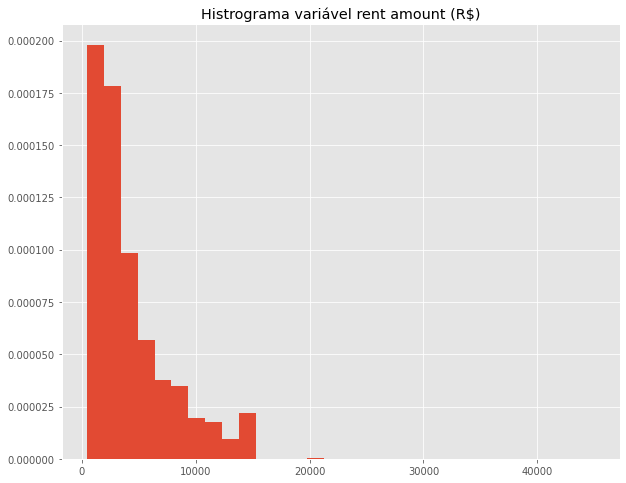

In [20]:
plt.figure(figsize=(10, 8))
plt.title('Histrograma variável rent amount (R$)')
plt.hist(df['rent amount (R$)'], density=True, bins=30)  # density=False would make counts


(array([0.00979498, 0.01732959, 0.04596107, 0.07534602, 0.13185554,
        0.28330105, 0.36919552, 0.35035901, 0.36316784, 0.50255798,
        0.42344465, 0.50105106, 0.50255798, 0.41063583, 0.35714015,
        0.4264585 , 0.33981057, 0.28179413, 0.26446454, 0.21021541,
        0.21925693, 0.19288582, 0.22679153, 0.00075346, 0.00527422,
        0.00075346, 0.00075346, 0.00075346, 0.        , 0.00075346]),
 array([ 6.10924758,  6.26275326,  6.41625893,  6.5697646 ,  6.72327027,
         6.87677595,  7.03028162,  7.18378729,  7.33729297,  7.49079864,
         7.64430431,  7.79780998,  7.95131566,  8.10482133,  8.258327  ,
         8.41183268,  8.56533835,  8.71884402,  8.87234969,  9.02585537,
         9.17936104,  9.33286671,  9.48637239,  9.63987806,  9.79338373,
         9.9468894 , 10.10039508, 10.25390075, 10.40740642, 10.5609121 ,
        10.71441777]),
 <BarContainer object of 30 artists>)

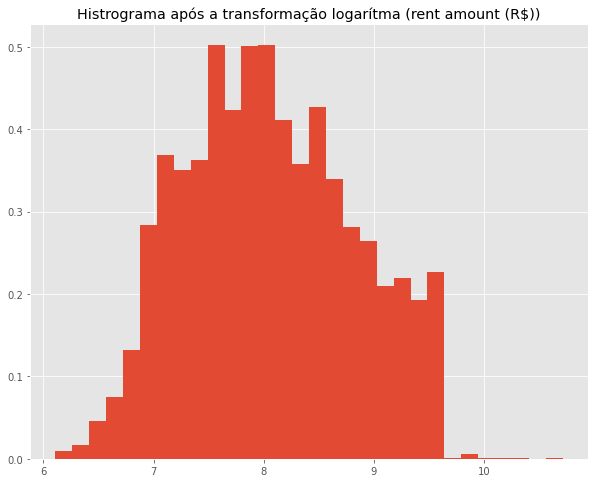

In [21]:
plt.figure(figsize=(10, 8))
plt.title('Histrograma após a transformação logarítma (rent amount (R$))')
plt.hist(np.log(df['rent amount (R$)']), density=True, bins=30)  # density=False would make counts


#### Foi aplicado a transformação logarítma com o intuito melhorar a simetria dos dados, 

### Transformando valores 

In [22]:
transformer = make_column_transformer((StandardScaler(), ['area', 'rooms', 'bathroom', 'parking spaces', 'floor']),(OneHotEncoder(), ['city']),(OrdinalEncoder(categories= [["not acept", "acept"]]),['animal']),(OrdinalEncoder(categories= [["not furnished", "furnished"]]),['furniture']))

In [23]:
df

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,rent amount (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,3300
1,São Paulo,320,4,4,0,20,acept,not furnished,4960
4,São Paulo,25,1,1,0,1,not acept,not furnished,800
5,São Paulo,376,3,3,7,0,acept,not furnished,8000
6,Rio de Janeiro,72,2,1,0,7,acept,not furnished,8000
...,...,...,...,...,...,...,...,...,...
10686,São Paulo,150,3,3,2,8,not acept,furnished,13500
10688,São Paulo,285,4,4,4,17,acept,not furnished,15000
10689,Rio de Janeiro,70,3,3,0,8,not acept,furnished,6000
10690,Rio de Janeiro,120,2,2,2,8,acept,furnished,12000


In [24]:
x = transformer.fit_transform(df)

In [25]:
pd.DataFrame(x)

,0,1,2,3,4,5,6,7,8,9
0,-0.149735,-0.482390,-0.927569,-0.424213,0.310230,0.0,0.0,1.0,1.0,1.0
1,0.282220,1.206171,1.157472,-1.037139,2.645585,0.0,0.0,1.0,1.0,0.0
2,-0.227486,-1.326671,-0.927569,-1.037139,-0.767627,0.0,0.0,1.0,0.0,0.0
3,0.378977,0.361890,0.462458,3.253341,-0.947270,0.0,0.0,1.0,1.0,0.0
4,-0.146279,-0.482390,-0.927569,-1.037139,0.310230,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
8641,-0.011509,0.361890,0.462458,0.188712,0.489872,0.0,0.0,1.0,0.0,1.0
8642,0.221746,1.206171,1.157472,1.414564,2.106657,0.0,0.0,1.0,1.0,0.0
8643,-0.149735,0.361890,0.462458,-1.037139,0.489872,0.0,1.0,0.0,0.0,1.0
8644,-0.063344,-0.482390,-0.232555,0.188712,0.489872,0.0,1.0,0.0,1.0,1.0


In [26]:
df_transf = pd.DataFrame(x, columns =['area', 'rooms', 'bathroom', 'parking spaces', 'floor','BH','RJ','SP', 'animal','furniture'] )

In [27]:
y  =np.log(df['rent amount (R$)'])

### Foi divido em 70% para treino e 30% para teste - essa % foi escolhida dado que 30% do dataset corresponde a 2594 linhas , dados o suficiente para se ter uma estimativa precisa do risco.

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Lasso

In [29]:
lambdas = np.logspace(-3, 0, 30)

In [30]:
lasso = Lasso()
grid = GridSearchCV(estimator=lasso, param_grid=dict(alpha=lambdas), cv=5, scoring = 'neg_mean_squared_error')
grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([0.001     , 0.00126896, 0.00161026, 0.00204336, 0.00259294,
       0.00329034, 0.00417532, 0.00529832, 0.00672336, 0.00853168,
       0.01082637, 0.01373824, 0.01743329, 0.02212216, 0.02807216,
       0.03562248, 0.04520354, 0.05736153, 0.07278954, 0.09236709,
       0.11721023, 0.14873521, 0.18873918, 0.23950266, 0.30391954,
       0.38566204, 0.48939009, 0.62101694, 0.78804628, 1.        ])},
             scoring='neg_mean_squared_error')

In [31]:
scores =(-grid.cv_results_['mean_test_score'])

(0.001, 1.0)

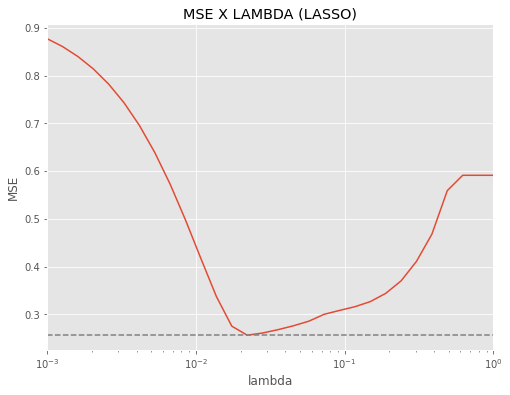

In [32]:
plt.figure().set_size_inches(8, 6)
plt.semilogx(lambdas, scores)
plt.ylabel('MSE')
plt.xlabel('lambda')
plt.title('MSE X LAMBDA (LASSO)')
plt.axhline(np.min(scores), linestyle='--', color='.5')
plt.xlim([lambdas[0], lambdas[-1]])

### Menor erro médio quadrado - lasso

In [33]:
np.min(scores)

0.2562082935608718

### Lambda que minimiza o MSE - lasso

In [34]:
lambdas[np.argmin(scores)]

0.022122162910704492

### Coefientes do modelo Lasso com lambda = 0.02395026619987486

In [35]:
reg_lasso = Lasso (alpha= lambdas[np.argmin(scores)])

In [36]:
reg_lasso.fit(x_train,y_train)

Lasso(alpha=0.022122162910704492)

In [37]:
reg_lasso.coef_

array([ 0.        ,  0.1419528 ,  0.28975791,  0.14742867,  0.06624944,
       -0.09811352, -0.        ,  0.04806138,  0.        ,  0.25603475])

In [38]:
coeff_df_lasso = pd.DataFrame(reg_lasso.coef_,df_transf.columns,columns=['Coefficient'])

In [39]:
coeff_df_lasso

,Coefficient
area,0.000000
rooms,0.141953
bathroom,0.289758
parking spaces,0.147429
floor,0.066249
BH,-0.098114
RJ,-0.000000
SP,0.048061
animal,0.000000
furniture,0.256035


### Intercepto - lasso

In [40]:
print('Intercepto:',reg_lasso.intercept_)

Intercepto: 7.979112198185916


### MAE / MSE / RMSE - lasso

In [60]:
y_pred_lasso = reg_lasso.predict(x_test)
print('MAE:', mean_absolute_error(np.exp(y_test), np.exp(y_pred_lasso)))
print('MSE:', mean_squared_error(np.exp(y_test),np.exp(y_pred_lasso)))
print('RMSE:', np.sqrt(mean_squared_error(np.exp(y_test),np.exp(y_pred_lasso))))

MAE: 1758.775544553853
MSE: 8850432.987780282
RMSE: 2974.967728863673


# Ridge

In [42]:
lambdas = np.logspace(-3, 8,100)

In [43]:
ridge = Ridge()
grid_ridge = GridSearchCV(estimator=ridge, param_grid=dict(alpha=lambdas), cv=5, scoring = 'neg_mean_squared_error')
grid_ridge.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-03, 1.29154967e-03, 1.66810054e-03, 2.15443469e-03,
       2.78255940e-03, 3.59381366e-03, 4.64158883e-03, 5.99484250e-03,
       7.74263683e-03, 1.00000000e-02, 1.29154967e-02, 1.66810054e-02,
       2.15443469e-02, 2.78255940e-02, 3.59381366e-02, 4.64158883e-02,
       5.99484250e-02, 7.74263683e-02, 1.00000000e-01, 1....
       2.78255940e+05, 3.59381366e+05, 4.64158883e+05, 5.99484250e+05,
       7.74263683e+05, 1.00000000e+06, 1.29154967e+06, 1.66810054e+06,
       2.15443469e+06, 2.78255940e+06, 3.59381366e+06, 4.64158883e+06,
       5.99484250e+06, 7.74263683e+06, 1.00000000e+07, 1.29154967e+07,
       1.66810054e+07, 2.15443469e+07, 2.78255940e+07, 3.59381366e+07,
       4.64158883e+07, 5.99484250e+07, 7.74263683e+07, 1.00000000e+08])},
             scoring='neg_mean_squared_error')

In [44]:
scores_ridge =-(grid_ridge.cv_results_['mean_test_score'])

(0.001, 100000000.0)

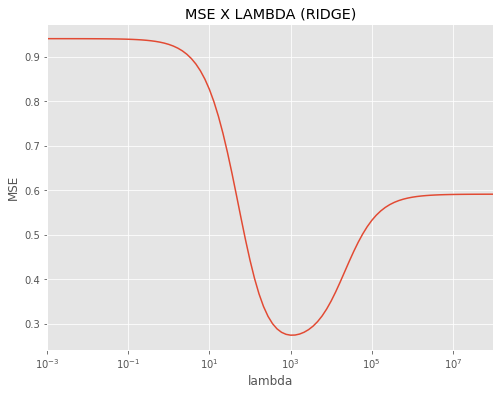

In [45]:
plt.figure().set_size_inches(8, 6)
plt.semilogx(lambdas, scores_ridge)
plt.ylabel('MSE')
plt.xlabel('lambda')
plt.title('MSE X LAMBDA (RIDGE)')
plt.xlim([lambdas[0], lambdas[-1]])

### Menor erro médio quadrado - ridge

In [46]:
np.min(scores_ridge)

0.2740849746071207

### Lambda que minimiza o MSE - ridge

In [47]:
lambdas[np.argmin(scores_ridge)]

1000.0

### Coefientes do modelo Ridge com lambda = 1000

In [48]:
reg_ridge = Ridge(alpha= lambdas[np.argmin(scores_ridge)])

In [49]:
reg_ridge.fit(x_train,y_train)

Ridge(alpha=1000.0)

In [50]:
reg_ridge.coef_

array([ 0.01264284,  0.16136797,  0.24473532,  0.15773263,  0.07898665,
       -0.10731456,  0.01375485,  0.09355971,  0.01214149,  0.19812567])

In [51]:
coeff_df_ridge = pd.DataFrame(reg_ridge.coef_,df_transf.columns,columns=['Coefficient'])

In [52]:
coeff_df_ridge

,Coefficient
area,0.012643
rooms,0.161368
bathroom,0.244735
parking spaces,0.157733
floor,0.078987
BH,-0.107315
RJ,0.013755
SP,0.093560
animal,0.012141
furniture,0.198126


### Intercepto - Ridge

In [53]:
print('Intercepto:',reg_ridge.intercept_)

Intercepto: 7.953063703376997


In [61]:
y_pred_ridge = reg_ridge.predict(x_test)
print('MAE:', mean_absolute_error(np.exp(y_test), np.exp(y_pred_ridge)))
print('MSE:', mean_squared_error(np.exp(y_test), np.exp(y_pred_ridge)))
print('RMSE:', np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_ridge))))

MAE: 1754.0840836998611
MSE: 8656046.885644427
RMSE: 2942.1160557742155
